In [20]:
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


In [21]:
input_folder = '/Users/jeffreyacquah/what_dog_am_i/customdataset2'
output_folder = '/Users/jeffreyacquah/what_dog_am_i/imagerecognition2'

split_ratio = (0.8,0.1,0.1)

splitfolders.ratio(

    input_folder,
    output=output_folder,
    seed=500,
    ratio = split_ratio,
    group_prefix = None
)

In [22]:
img_size = (224,224)
batch_size = 32 # Model updates weights after processing 32 images

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

In [23]:
# Rescale pixel values, without any extra augmentation processes for test and validation data

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [24]:
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_data = valid_datagen.flow_from_directory(
    val_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 118 images belonging to 3 classes.
Found 17 images belonging to 3 classes.
Found 14 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..138.22101].


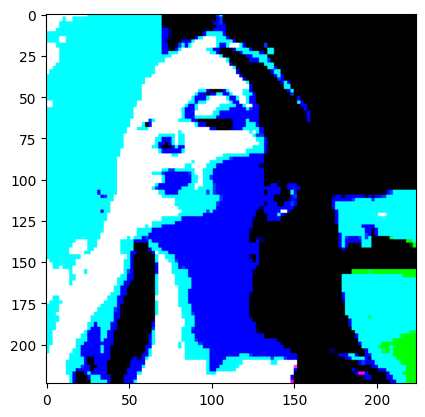

In [25]:
images, labels = next(valid_data)
idx = random.randint(0,images.shape[0]-1)

plt.imshow(images[idx])
plt.show()

In [26]:
from keras.applications.resnet import ResNet50
base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(img_size[0], img_size[1], 3))

#base_model.trainable = False # Only trains newly added classification layers

for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Later layers for higher level features (eyes, mouth, emotion cues) will be retrained
                      

In [27]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')


])

In [28]:
model.compile(
    optimizer = Adam(learning_rate=1e-5), #lower learning rate for fine tuning
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [29]:
model.fit(train_data, epochs = 50, validation_data = valid_data)

/Users/jeffreyacquah/what_dog_am_i/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3220 - loss: 1.4931 - val_accuracy: 0.2143 - val_loss: 1.3540
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4068 - loss: 1.3628 - val_accuracy: 0.3571 - val_loss: 1.2942
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4322 - loss: 1.2907 - val_accuracy: 0.4286 - val_loss: 1.2435
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4068 - loss: 1.3488 - val_accuracy: 0.4286 - val_loss: 1.1977
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4746 - loss: 1.2718 - val_accuracy: 0.4286 - val_loss: 1.1569
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5593 - loss: 1.0978 - val_accuracy: 0.4286 - val_loss: 1.1214
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5932 - loss: 0.9388 - val_accuracy: 0.5000 - val_loss: 1.0904
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4915 - loss: 1.0665 - val_accuracy: 0.5714 - val_loss: 1.0606
Epoch 9/50
4/4 

In [30]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8824 - loss: 0.6289
Test Accuracy: 88.24%


In [31]:
class_names = {0: 'eyesclosed',
               1: 'scream',
               2: 'tongue_out'
               }

In [32]:
def predict_img(image,model):
    test_img=cv2.imread(image)
    test_img=cv2.resize(test_img,(224,224))
    test_img=np.expand_dims(test_img,axis=0)
    result=model.predict(test_img)
    r = np.argmax(result)
    print(class_names[r])

In [33]:
predict_img('customdataset/tongue/tongue_2.jpeg',model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
scream


In [35]:
model.save('CustomNetworkv2.keras')